# Movie Data Analysis
by Michael Kearns

# Business Understanding

The company is creating a new movie studio and needs insight into which types of movies to make. My analysis will provide information on which types of movies have had the most success in recent years, and I will provide suggestions to the head of the movie studio on how to proceed. 

# Data Understanding

Explain what the data is and where it comes from

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np

%matplotlib inline

In [2]:
#Connect to IMDB sql database
conn = sqlite3.connect('data/im.db')


In [3]:
file_names = ['data/bom.movie_gross.csv.gz','data/rt.movie_info.tsv.gz','data/rt.reviews.tsv.gz', \
              'data/tmdb.movies.csv.gz', 'data/tn.movie_budgets.csv.gz']

file_types = [',','\t','\t',',',',']


In [4]:
df1 = pd.read_csv(file_names[0],sep = file_types[0])
df2 = pd.read_csv(file_names[1],sep = file_types[1])
df3 = pd.read_csv(file_names[2],sep = file_types[2], encoding = 'latin-1')
df4 = pd.read_csv(file_names[3],sep = file_types[3])
df5 = pd.read_csv(file_names[4],sep = file_types[4])

dfs = [df1, df2, df3, df4, df5]

for j in range(0,5):
    print(f'Data Frame: {file_names[j]}')
    print(dfs[j].head)

Data Frame: data/bom.movie_gross.csv.gz
<bound method NDFrame.head of                                             title      studio  domestic_gross  \
0                                     Toy Story 3          BV     415000000.0   
1                      Alice in Wonderland (2010)          BV     334200000.0   
2     Harry Potter and the Deathly Hallows Part 1          WB     296000000.0   
3                                       Inception          WB     292600000.0   
4                             Shrek Forever After        P/DW     238700000.0   
...                                           ...         ...             ...   
3382                                    The Quake       Magn.          6200.0   
3383                  Edward II (2018 re-release)          FM          4800.0   
3384                                     El Pacto        Sony          2500.0   
3385                                     The Swan  Synergetic          2400.0   
3386                            An Acto

### Summary of Data

In [5]:
#column names in each dataframe
for j in range(0,5):
    print(f'Data Frame: {file_names[j]}')
    print(dfs[j].columns)

Data Frame: data/bom.movie_gross.csv.gz
Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')
Data Frame: data/rt.movie_info.tsv.gz
Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')
Data Frame: data/rt.reviews.tsv.gz
Index(['id', 'review', 'rating', 'fresh', 'critic', 'top_critic', 'publisher',
       'date'],
      dtype='object')
Data Frame: data/tmdb.movies.csv.gz
Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')
Data Frame: data/tn.movie_budgets.csv.gz
Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')


## Data Preparatation

In [6]:
for j in range(0,5):
    print(f'Data Frame: df{j+1}')
    print(dfs[j].info())

Data Frame: df1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None
Data Frame: df2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   

In [7]:
df5[df5['movie'] == 'Iron Man 2']

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
114,15,"May 7, 2010",Iron Man 2,"$170,000,000","$312,433,331","$621,156,389"


In [8]:
df5

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [9]:
#Create copy of df5
movie_gross = df5.copy()

In [10]:
#Remove rows that do not have domestic gross data
movie_gross.dropna(axis = 0, subset=['domestic_gross'],inplace = True)

In [11]:
movie_gross = movie_gross[['movie','domestic_gross','worldwide_gross','production_budget']]
movie_gross.rename(columns={'movie': 'Title'}, inplace=True)

In [13]:
cols = ['domestic_gross','worldwide_gross','production_budget']
for col in cols:
    movie_gross[col]=movie_gross[col].apply(lambda x: x.replace('$','').replace(',',''))
    movie_gross[col]=movie_gross[col].astype(float)

In [15]:
q = """ SELECT primary_title AS Title, start_year AS Year, genres AS Genres
    FROM movie_basics
    WHERE Year <= 2021
    ORDER BY Year
;"""

movie_genre = pd.read_sql(q,conn)
movie_genre

,Title,Year,Genres
0,Pál Adrienn,2010,Drama
1,So Much for Justice!,2010,History
2,Children of the Green Dragon,2010,Drama
3,The Final Journey,2010,Drama
4,Quantum Quest: A Cassini Space Odyssey,2010,"Adventure,Animation,Sci-Fi"
...,...,...,...
146096,FlabberGasted,2021,Animation
146097,Golmaal 5,2021,"Adventure,Comedy,Mystery"
146098,Mission: Impossible 7,2021,"Action,Adventure,Thriller"
146099,Hotel Transylvania 4,2021,"Adventure,Animation,Comedy"


In [16]:
#combine movie titles and genres together
movie_genre_gross = pd.merge(movie_gross,movie_genre, on = 'Title', how = 'inner')
#drop movie rows with no genre
movie_genre_gross.dropna(axis = 0, subset=['Genres'],inplace = True)
#separate genres if movie is identified with multiple genres
movie_genre_gross[['Genre 1', 'Genre 2', 'Genre 3']] = movie_genre_gross['Genres'].str.split(',', expand=True)

In [17]:
#Group by genre to get the sum of Domestic Gross revenue.
genre1 = movie_genre_gross.groupby('Genre 1').sum()['domestic_gross']
genre2 = movie_genre_gross.groupby('Genre 2').sum()['domestic_gross']
genre3 = movie_genre_gross.groupby('Genre 3').sum()['domestic_gross']

In [22]:
#get total domestic gross per genre
dg_genre = pd.concat([genre1,genre2,genre3],axis = 1)
dg_genre.columns= ['dg1','dg2','dg3']
#set NaN to 0
dg_genre = dg_genre.fillna(0)
#sum total domestic gross
dg_genre['total_domestic_gross'] = dg_genre['dg1']+dg_genre['dg2']+dg_genre['dg3']
dg_genre = dg_genre.reset_index()
dg_genre.rename(columns={'index':'Genre'},inplace = True)
dg_genre.sort_values(by='total_domestic_gross',ascending = False,inplace = True)

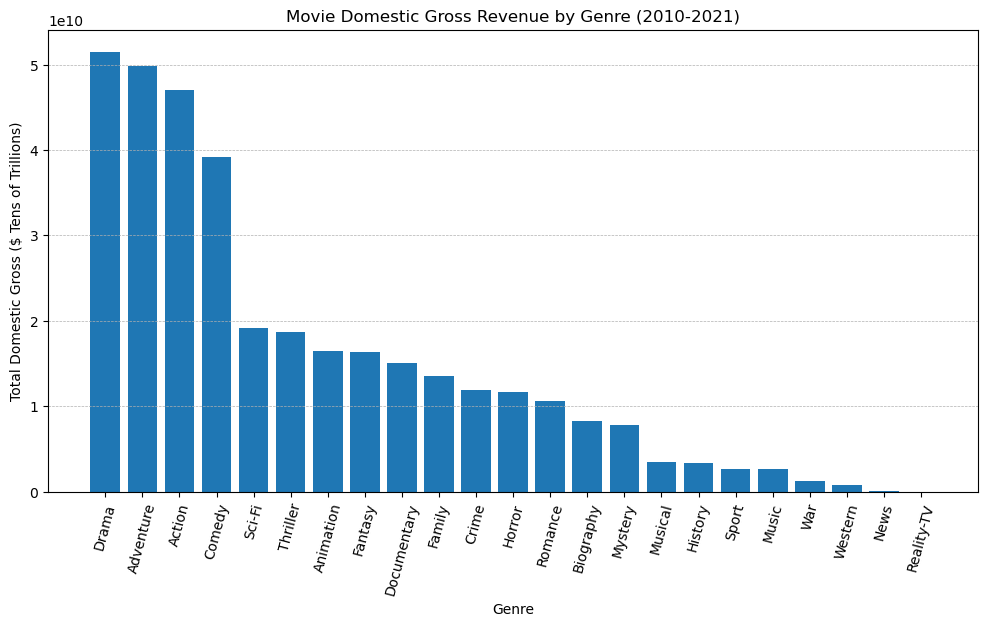

In [23]:
#Plot Bar Graph of Total Domestic Gross
fig , ax = plt.subplots(figsize=(12,6))

x = dg_genre['Genre']
y = dg_genre['total_domestic_gross']

plot = ax.bar(x = x, height = y)
ax.set_xlabel('Genre')
ax.set_ylabel('Total Domestic Gross ($ Tens of Trillions)')
ax.set_title ('Movie Domestic Gross Revenue by Genre (2010-2021)')
ax.tick_params(axis='x', labelrotation=75)
ax.grid(visible = True, which = 'both', axis = "y",linestyle='--', linewidth=0.5);


# Exploratory Data Analysis

1. What genre has the highest average domestic and worldwide gross revenue? In the last 10 years.
2. Which genre type results in the highest profits?

# Conclusion

## Limitations

## Recommendations

## Next Steps